In [1]:
import numpy, seaborn, pandas
import scipy.stats as stats
from scipy.stats import gaussian_kde
import matplotlib, matplotlib.pyplot as plt

import re #to search

C:\Users\kja11\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:
file_directory = "/Users/kja11/OneDrive - Menntaský (1)/Mild_Hypothermia_project/in_silico/Python/"

input_path = "1) input/flow_cytometry/"
output_path = "3) output/flow_cytometry/"

# Data download and modifications

## Meta and statitics data

In [5]:
# Meta data, important for sample_name
df_meta = pandas.read_csv(file_directory + input_path + 'ribosome_concat_cirbp_exp2_table.csv', sep = ',')

# Interested in name and Mode (the most frequently occurring value)
df_meta = df_meta.rename(columns = {'Unnamed: 0' : 'sample_name',
                                    'HEK293/Single Cells | Count' : 'count',
                                    'HEK293/Single Cells | Geometric Mean (PE-Cy7-A)' : 'gMFI'})
print(df_meta.shape, '\n')
df_meta.tail(5)

(9, 3) 



,sample_name,count,gMFI
4,Samples_mCherry cirbp RPL6B 37.fcs,30494,13429.0
5,Samples_mCherry cirbp ctl 37.fcs,35440,12230.0
6,Samples_mCherry cirbp ctl 32.fcs,27510,16389.0
7,Mean,30416,12460.0
8,SD,3808,5635.0


In [6]:
# remove the last rows
df_meta = df_meta[(df_meta['sample_name'] != 'Mean') & (df_meta['sample_name'] != 'SD')]
df_meta.tail()

,sample_name,count,gMFI
2,Samples_mCherry cirbp RPL6A 37.fcs,33154,14215.0
3,Samples_mCherry cirbp RPL6B 32.fcs,33744,15744.0
4,Samples_mCherry cirbp RPL6B 37.fcs,30494,13429.0
5,Samples_mCherry cirbp ctl 37.fcs,35440,12230.0
6,Samples_mCherry cirbp ctl 32.fcs,27510,16389.0


In [7]:
# Have to rename the samples to have clear labelling  
sample_name = df_meta.sample_name

# select the three meta info
df_meta['Temperature'] = sample_name.apply(lambda x: re.search(r'\b(32|37)\b', x).group()
                                           if re.search(r'\b(32|37)\b', x) 
                                           else None)

df_meta['mhi-target'] = sample_name.apply(lambda x: re.search(r'(rbm3|sp1|cirbp)', x, re.IGNORECASE).group().lower()
                                           if re.search(r'(rbm3|sp1|cirbp)', x, re.IGNORECASE) 
                                           else None)

df_meta['condition'] = sample_name.apply(lambda x: re.search(r'(Unstained|ctl|rpl6a|rpl6b|rpl40)', x, re.IGNORECASE).group().lower()
                                          if re.search(r'(Unstained|ctl|rpl6a|rpl6b|rpl40)', x, re.IGNORECASE) 
                                          else None)

df_meta.loc[df_meta['condition'] == 'unstained', ['mhi-target', 'Temperature']] = ['HEK293', 'control']

df_meta

,sample_name,count,gMFI,Temperature,mhi-target,condition
0,Samples_Unstained.fcs,25740,86.2,control,HEK293,unstained
1,Samples_mCherry cirbp RPL6A 32.fcs,26829,15125.0,32,cirbp,rpl6a
2,Samples_mCherry cirbp RPL6A 37.fcs,33154,14215.0,37,cirbp,rpl6a
3,Samples_mCherry cirbp RPL6B 32.fcs,33744,15744.0,32,cirbp,rpl6b
4,Samples_mCherry cirbp RPL6B 37.fcs,30494,13429.0,37,cirbp,rpl6b
5,Samples_mCherry cirbp ctl 37.fcs,35440,12230.0,37,cirbp,ctl
6,Samples_mCherry cirbp ctl 32.fcs,27510,16389.0,32,cirbp,ctl


In [8]:
label_serie = df_meta[['mhi-target', 'condition', 'Temperature']].agg('_'.join, axis=1)
df_meta.insert(0, "label", label_serie)
df_meta.head()

,label,sample_name,count,gMFI,Temperature,mhi-target,condition
0,HEK293_unstained_control,Samples_Unstained.fcs,25740,86.2,control,HEK293,unstained
1,cirbp_rpl6a_32,Samples_mCherry cirbp RPL6A 32.fcs,26829,15125.0,32,cirbp,rpl6a
2,cirbp_rpl6a_37,Samples_mCherry cirbp RPL6A 37.fcs,33154,14215.0,37,cirbp,rpl6a
3,cirbp_rpl6b_32,Samples_mCherry cirbp RPL6B 32.fcs,33744,15744.0,32,cirbp,rpl6b
4,cirbp_rpl6b_37,Samples_mCherry cirbp RPL6B 37.fcs,30494,13429.0,37,cirbp,rpl6b


In [9]:
# Calculate Geometric mean fluorescence ratio
gMFI_control = df_meta[df_meta.label == 'HEK293_unstained_control']['gMFI'].iloc[0]
df_meta = df_meta.assign(gMFI_ratio = (df_meta.gMFI/gMFI_control))

# Add SampleID to merge with the flow data
df_meta['SampleID'] = ''
df_meta['SampleID'] = range(1, len(df_meta) + 1)
df_meta = df_meta[['label','SampleID', 'gMFI_ratio']]
df_meta.head()

,label,SampleID,gMFI_ratio
0,HEK293_unstained_control,1,1.000000
1,cirbp_rpl6a_32,2,175.464037
2,cirbp_rpl6a_37,3,164.907193
3,cirbp_rpl6b_32,4,182.645012
4,cirbp_rpl6b_37,5,155.788863


## Flow data

In [16]:
#data Flow Cytometry
df = pandas.read_csv(file_directory + input_path + 'ribosome_concat_cirbp_exp2.csv', sep = ',')

# What channel for mCherry ? For this exepriemnent PE-CY7 for CIRBP ; PE-CF594 for RBM3 & SP1
df = df.rename(columns = {'PE-Cy7-A' : 'mCherry-A'})

print(df.shape, '\n')
df

(212911, 12) 



,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,PE-A,PE-CF594-A,PE-Cy5-A,mCherry-A,Time,SampleID
0,62295.4,32384.3,144282,29675.9,21099.1,92991.2,88.5062,77.5324,75.2865,118.7710,0.030845,1
1,68085.5,38850.8,165748,47785.5,32037.7,113278.0,35.4339,112.8040,53.0315,148.8140,0.032265,1
2,68089.3,34438.6,157964,58353.7,37813.9,109504.0,66.1386,123.6490,173.0900,124.0100,0.032632,1
3,108288.0,66650.9,152546,40765.6,28259.6,97934.6,80.3233,101.8770,69.0905,92.3209,0.034947,1
4,53583.2,32323.4,148347,33142.1,24911.1,94118.6,109.4850,184.1770,50.3856,56.4774,0.035610,1
...,...,...,...,...,...,...,...,...,...,...,...,...
212906,41977.2,21433.0,175169,49971.3,19421.5,138500.0,95318.8000,188142.0000,116114.0000,43814.1000,82.857900,7
212907,62124.8,33566.6,157295,50663.9,27334.3,126918.0,214904.0000,421212.0000,260848.0000,96228.6000,82.859000,7
212908,103827.0,52262.5,225389,63858.1,33721.0,195479.0,29982.0000,60482.0000,38535.2000,15533.6000,82.859600,7
212909,84832.6,52519.1,168712,64089.4,39173.9,114725.0,241786.0000,463227.0000,290048.0000,107156.0000,82.862100,7


In [17]:
print(f'Amount of SampleID: {df.SampleID.max()-1}')
print(f'Amount of meta-info label: {len(df_meta.label.unique())}')

Amount of SampleID: 6
Amount of meta-info label: 7


## Merge

In [18]:
# merge 
df = df_meta.merge(df)
df = df.drop(['SampleID', 'Time', 'gMFI_ratio'], axis=1)
df

,label,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,PE-A,PE-CF594-A,PE-Cy5-A,mCherry-A
0,HEK293_unstained_control,62295.4,32384.3,144282,29675.9,21099.1,92991.2,88.5062,77.5324,75.2865,118.7710
1,HEK293_unstained_control,68085.5,38850.8,165748,47785.5,32037.7,113278.0,35.4339,112.8040,53.0315,148.8140
2,HEK293_unstained_control,68089.3,34438.6,157964,58353.7,37813.9,109504.0,66.1386,123.6490,173.0900,124.0100
3,HEK293_unstained_control,108288.0,66650.9,152546,40765.6,28259.6,97934.6,80.3233,101.8770,69.0905,92.3209
4,HEK293_unstained_control,53583.2,32323.4,148347,33142.1,24911.1,94118.6,109.4850,184.1770,50.3856,56.4774
...,...,...,...,...,...,...,...,...,...,...,...
212906,cirbp_ctl_32,41977.2,21433.0,175169,49971.3,19421.5,138500.0,95318.8000,188142.0000,116114.0000,43814.1000
212907,cirbp_ctl_32,62124.8,33566.6,157295,50663.9,27334.3,126918.0,214904.0000,421212.0000,260848.0000,96228.6000
212908,cirbp_ctl_32,103827.0,52262.5,225389,63858.1,33721.0,195479.0,29982.0000,60482.0000,38535.2000,15533.6000
212909,cirbp_ctl_32,84832.6,52519.1,168712,64089.4,39173.9,114725.0,241786.0000,463227.0000,290048.0000,107156.0000


In [19]:
df.label.unique()

array(['HEK293_unstained_control', 'cirbp_rpl6a_32', 'cirbp_rpl6a_37',
       'cirbp_rpl6b_32', 'cirbp_rpl6b_37', 'cirbp_ctl_37', 'cirbp_ctl_32'],
      dtype=object)

# Graphics

In [20]:
# Define a function to process data and calculate KDE
def process_and_plot(sample_data, color, label):
    data = sample_data['mCherry-A'].apply(numpy.log10)
    data = data[numpy.isfinite(data)] #not have infinte or nan
    
    # perform Kernel Density Estimation
    kde = gaussian_kde(data)
    x = numpy.linspace(min(data), max(data), 1000)
    y = kde(x)
    
    # normalize to have y from 0 to 100
    peak_y = numpy.max(y)
    normalized_y = (y / peak_y) * 100
    
    # find Mode
    mode_index = numpy.argmax(y)
    mode_value = x[mode_index]

    # Plot 
    plt.plot(x, normalized_y, color=color, alpha=0.7, label=f'{label}; {MHI.upper()}-MHI si{condition.upper()}' if label.startswith('3') else f'{label}')
    plt.fill_between(x, normalized_y, color=color, alpha=0.3) # fill the curve
    plt.axvline(mode_value, color=color, linestyle='--') # add vertical line 
    
    return mode_value # return to see if one sample is missing 

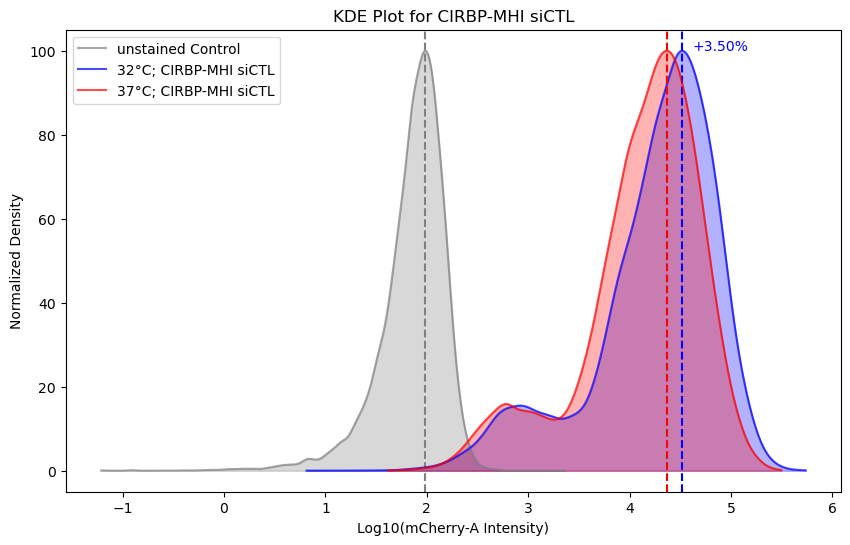

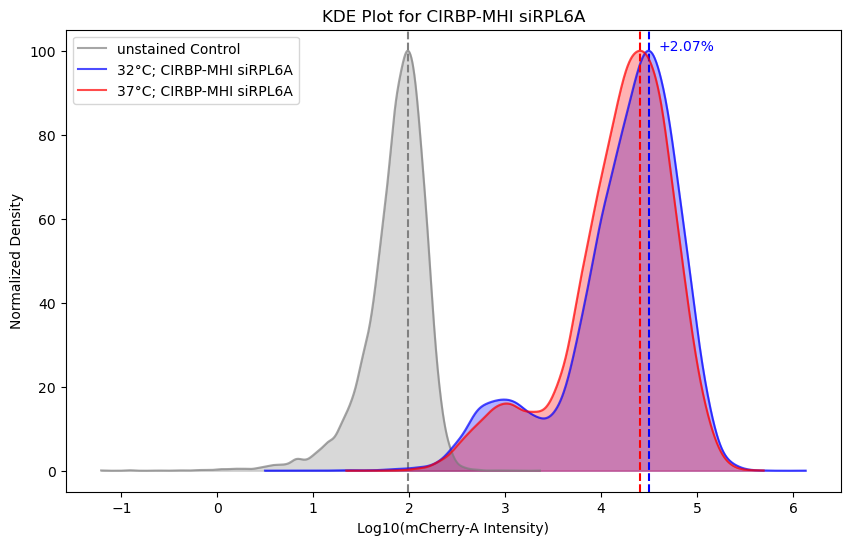

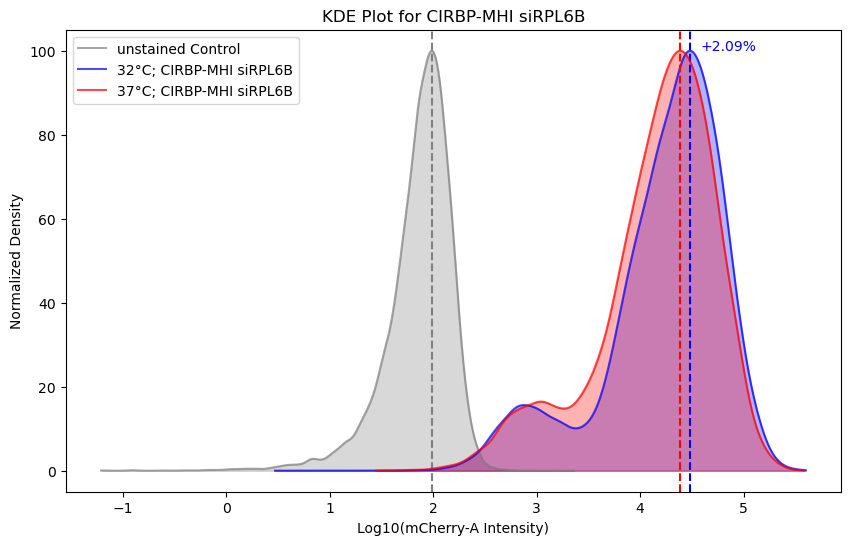

Missing samples are: ['rbm3_ctl_32', 'rbm3_rpl6a_32', 'rbm3_rpl6b_32', 'rbm3_rpl40_32', 'sp1_ctl_32', 'sp1_rpl6a_32', 'sp1_rpl6b_32', 'sp1_rpl40_32', 'cirbp_rpl40_32']


In [21]:
# Define parameters
unstained_control = 'HEK293_unstained_control'
temperatures = [32, 37]
MHIs = ['rbm3', 'sp1', 'cirbp']
conditions = ['ctl', 'rpl6a', 'rpl6b', 'rpl40']

# Loop over MHIs and conditions
missing_samples_l = []

for MHI in MHIs:
    for condition in conditions:
        fig = plt.figure(figsize=(10, 6))

        # Plot the Unstained control
        sample_control = df[df['label'] == unstained_control]
        process_and_plot(sample_control, 'gray', 'unstained Control')
        
        mode_32 = None
        mode_37 = None
        missing_sample = False
        
        for temp, color in zip(temperatures, ['blue', 'red']):
            label = f'{MHI}_{condition}_{temp}'
            sample = df[df['label'] == label]
            
            # if one sample is missing, stop
            if sample.empty:
                missing_samples_l.append(label)
                missing_sample = True
                break 
            
            # save mode value to calculate % later
            mode_value = process_and_plot(sample, color, f'{temp}°C')
            if temp == 32:
                mode_32 = mode_value
            elif temp == 37:
                mode_37 = mode_value
                
        # Close the plot if any sample is missing        
        if missing_sample:
            plt.close(fig)  
            continue
                
        # Calculate and annotate percentage change if both modes are available
        if mode_32 is not None and mode_37 is not None:
            percent_change = ((mode_32 - mode_37) / mode_37) * 100
            plt.text(mode_32 + 0.1, 100, f'{percent_change:+.2f}%', color='blue', fontsize=10)

        # Add labels and legend
        plt.xlabel('Log10(mCherry-A Intensity)')
        plt.ylabel('Normalized Density')
        plt.title(f'KDE Plot for {MHI.upper()}-MHI si{condition.upper()}')
        plt.legend(loc='upper left')

        # Save the graph
        filename = f'{MHI}_{condition}_KDE_plot.png'
        # plt.savefig(filename)
        plt.show()
        plt.close(fig)

#print missing samples   
print(f'Missing samples are: {missing_samples_l}')